In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.random.set_seed(2)
np.random.seed(1)
# print(os.listdir("../input"))

In [ ]:
InputPath="/bin/download.jpeg"

In [ ]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

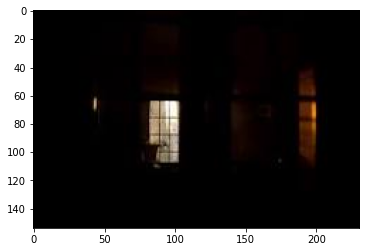

In [ ]:
img = cv.imread(InputPath)  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)


<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


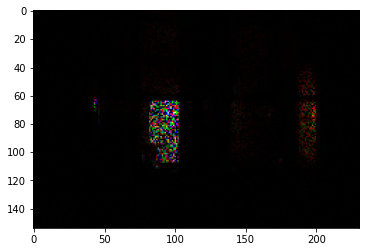

In [ ]:
Noise = noisy("s&p",img)
plt.imshow(Noise)

<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


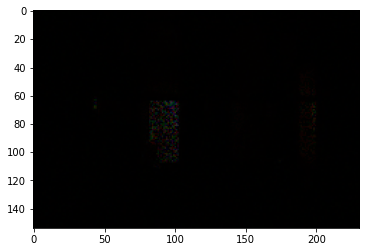

In [ ]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [ ]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<2131:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(500,500))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [ ]:
X_,y_ = PreProcessData("/bin/")

<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


In [ ]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5

In [ ]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 500, 500, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 500, 500, 32  896         ['input_1[0][0]']                
                                )                                                             

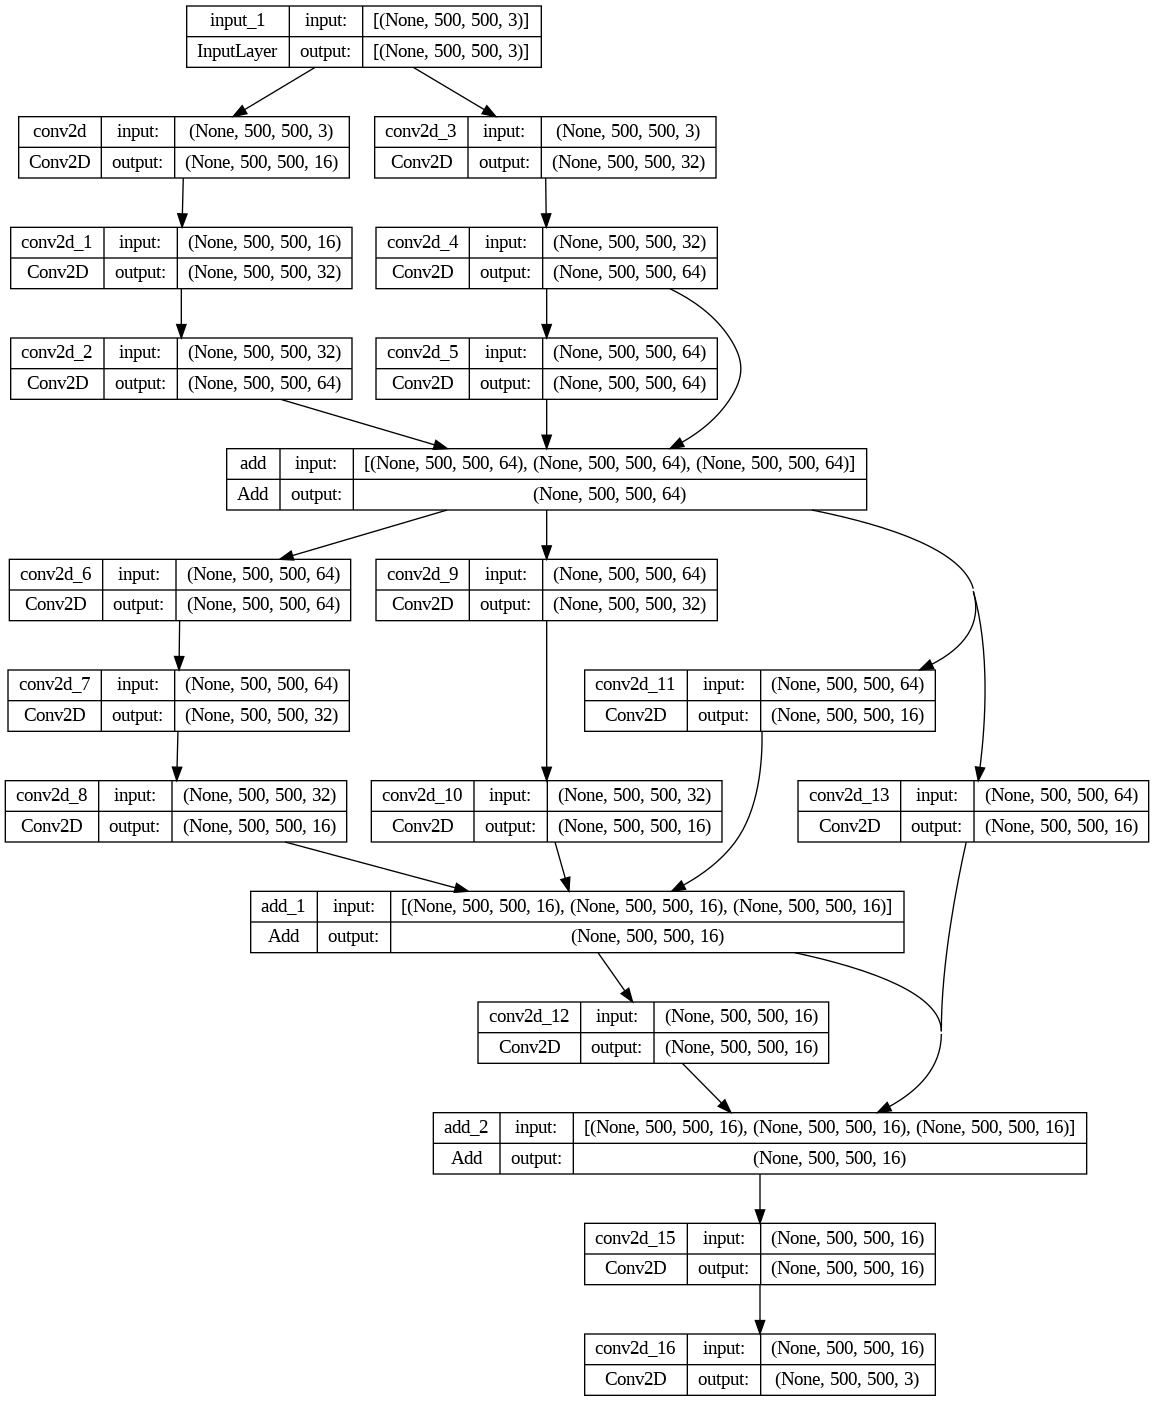

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)

<ipython-input-13-c5f0e23b4ee9>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)


Epoch 1/53
 3/39 [=>............................] - ETA: 6:45 - loss: 7415.4785 

39/39 [==============================] - 37s 601ms/step - loss: 7415.4785


In [ ]:
TestPath="/bin/download.jpeg"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

In [ ]:
ImagePath=TestPath
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


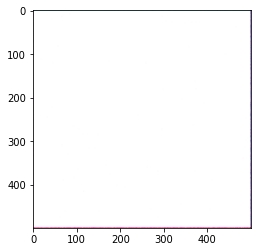

In [ ]:
Prediction = Prediction.reshape(500,500,3)
plt.imshow(Prediction)

<ipython-input-24-1b158654e930>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,1+1)
<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


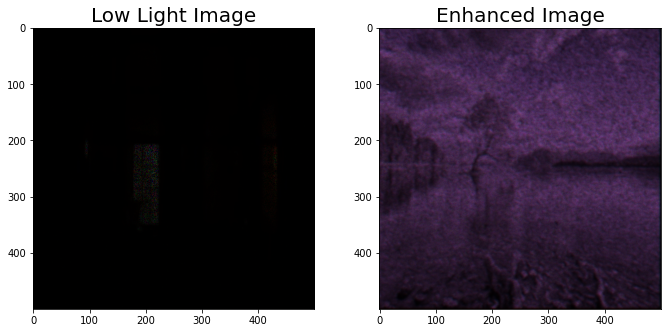

In [ ]:
Image_test=TestPath
plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
# plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

In [ ]:
TestPath2="/bin/2.jpg"

<ipython-input-25-ade50f2a8d24>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,1+1)
<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


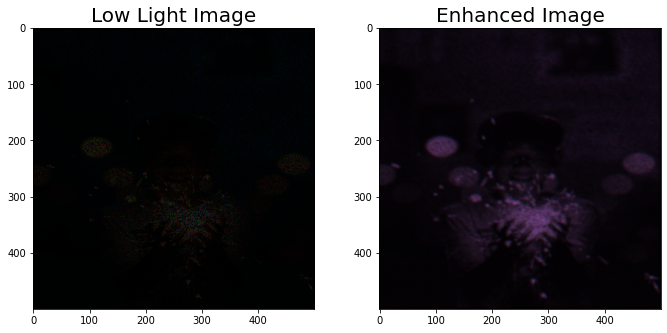

In [ ]:
Image_test2=TestPath2
plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
# plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

<ipython-input-26-9d101a801610>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,1+1)
<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


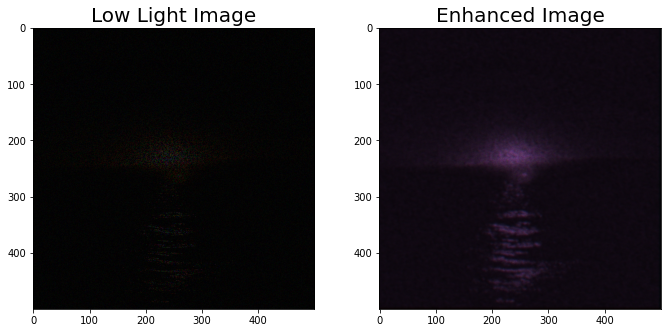

In [ ]:
Image_test2="/bin/1.jpg"
plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
# plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

<ipython-input-27-2e5e1b125348>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,1+1)
<ipython-input-3-17061be22c44>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-3-17061be22c44>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1


1/1 [==============================] - 2s 2s/step


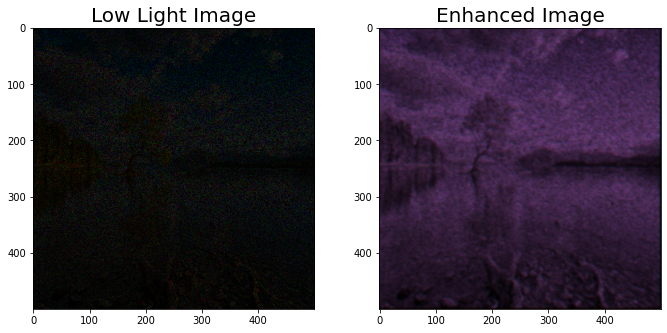

In [ ]:
Image_test2="/bin/3.jpeg"
plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
# plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)